In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cascade-cup-22/sample_submission.csv
/kaggle/input/cascade-cup-22/train.csv
/kaggle/input/cascade-cup-22/test.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

VALID_TRAIN_SPLIT = 0.2
TEST_SPLIT_RATIO  = 0.2
SEED = 42

In [3]:
data_df = pd.read_csv('/kaggle/input/cascade-cup-22/train.csv')
test_df = pd.read_csv('/kaggle/input/cascade-cup-22/test.csv')
print('DATA loaded ...')
print(f'Train Columns : {data_df.shape[1]}   Rows : {data_df.shape[0]}')
print(f'Test Columns : {test_df.shape[1]}   Rows : {test_df.shape[0]}')

DATA loaded ...
Train Columns : 20   Rows : 450000
Test Columns : 16   Rows : 144844


In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype.name
        
        if col_type not in ['object', 'category', 'datetime64[ns, UTC]', 'datetime64[ns]']:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [5]:
data_df = reduce_mem_usage(data_df)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 68.66 MB
Memory usage after optimization is: 41.20 MB
Decreased by 40.0%
Memory usage of dataframe is 17.68 MB
Memory usage after optimization is: 9.67 MB
Decreased by 45.3%


In [6]:
data_df.head(10)

,order_time,order_id,order_date,allot_time,accept_time,pickup_time,delivered_time,rider_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,cancelled,undelivered_orders,lifetime_order_count,reassignment_method,reassignment_reason,reassigned_order,session_time,cancelled_time
0,2021-01-26 02:21:35,556753,2021-01-26 00:00:00,2021-01-26 02:21:59,2021-01-26 02:22:08,2021-01-26 02:32:51,2021-01-26 02:49:47,11696,1.566406,2.650391,46.0,46.0,0,0.0,621.0,NaN,NaN,NaN,NaN,NaN
1,2021-01-26 02:33:16,556754,2021-01-26 00:00:00,2021-01-26 02:33:57,2021-01-26 02:34:45,2021-01-26 02:50:25,2021-01-26 03:11:15,18117,2.521484,2.759766,8.0,8.0,0,0.0,105.0,NaN,NaN,NaN,3.267578,NaN
2,2021-01-26 02:39:49,556755,2021-01-26 00:00:00,2021-01-26 02:39:57,2021-01-26 02:40:13,2021-01-26 02:56:00,2021-01-26 03:12:46,18623,2.207031,4.800781,1.0,1.0,0,0.0,66.0,NaN,NaN,NaN,9.820312,NaN
3,2021-01-26 02:47:53,556756,2021-01-26 00:00:00,2021-01-26 02:48:25,2021-01-26 02:49:06,2021-01-26 03:21:51,2021-01-26 03:41:05,15945,2.189453,6.378906,1.0,1.0,0,0.0,127.0,NaN,NaN,NaN,17.531250,NaN
4,2021-01-26 03:06:30,556757,2021-01-26 00:00:00,2021-01-26 03:07:21,2021-01-26 03:07:57,2021-01-26 03:31:38,2021-01-26 04:00:15,17589,2.787109,4.011719,34.0,34.0,0,0.0,84.0,NaN,NaN,NaN,1.349609,NaN
5,2021-01-26 03:07:16,556758,2021-01-26 00:00:00,2021-01-26 03:12:14,2021-01-26 03:12:27,2021-01-26 03:25:36,2021-01-26 03:45:51,1469,2.482422,5.179688,296.0,294.0,0,2.0,1506.0,NaN,NaN,NaN,NaN,NaN
6,2021-01-26 03:10:50,556759,2021-01-26 00:00:00,2021-01-26 03:11:18,2021-01-26 03:12:05,2021-01-26 03:19:31,2021-01-26 03:26:04,8851,2.808594,3.400391,45.0,45.0,0,0.0,1460.0,NaN,NaN,NaN,NaN,NaN
7,2021-01-26 03:14:10,556760,2021-01-26 00:00:00,2021-01-26 03:14:38,2021-01-26 03:14:44,2021-01-26 03:33:53,2021-01-26 03:42:38,8493,0.025681,0.160034,54.0,53.0,0,1.0,270.0,NaN,NaN,NaN,44.156250,NaN
8,2021-01-26 03:14:20,556761,2021-01-26 00:00:00,2021-01-26 03:14:50,2021-01-26 03:15:14,2021-01-26 04:00:02,2021-01-26 04:13:31,11543,2.443359,2.859375,29.0,29.0,0,0.0,955.0,NaN,NaN,NaN,2.500000,NaN
9,2021-01-26 03:15:18,556762,2021-01-26 00:00:00,2021-01-26 03:21:27,2021-01-26 03:22:04,2021-01-26 04:14:56,2021-01-26 04:38:39,21037,2.878906,2.609375,NaN,NaN,0,NaN,1.0,auto,Reassignment Request from SE portal.,1.0,NaN,NaN


In [7]:
test_df.head(10)

,order_time,order_id,order_date,allot_time,accept_time,rider_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,undelivered_orders,lifetime_order_count,reassignment_method,reassignment_reason,reassigned_order,session_time
0,2021-02-06 10:03:24,130231,2021-02-06 00:00:00,2021-02-06 10:03:49,2021-02-06 10:04:15,12884,1.658203,4.539062,216.0,215.0,1.0,747.0,NaN,NaN,NaN,273.5000
1,2021-02-06 10:03:26,130232,2021-02-06 00:00:00,2021-02-06 10:03:27,2021-02-06 10:03:36,3541,2.070312,5.839844,52.0,52.0,0.0,75.0,NaN,NaN,NaN,252.1250
2,2021-02-06 10:03:27,130233,2021-02-06 00:00:00,2021-02-06 10:04:14,2021-02-06 10:05:34,603,1.388672,0.990234,289.0,289.0,0.0,2214.0,NaN,NaN,NaN,241.3750
3,2021-02-06 10:03:29,130234,2021-02-06 00:00:00,2021-02-06 10:03:30,2021-02-06 10:03:53,3414,1.904297,2.589844,125.0,122.0,3.0,1020.0,NaN,NaN,NaN,292.0000
4,2021-02-06 10:03:35,130235,2021-02-06 00:00:00,2021-02-06 10:03:43,2021-02-06 10:04:43,1426,0.827637,0.939941,352.0,350.0,2.0,7284.0,NaN,NaN,NaN,247.1250
5,2021-02-06 10:03:39,130237,2021-02-06 00:00:00,2021-02-06 10:04:01,2021-02-06 10:05:29,231,0.879883,5.488281,5.0,5.0,0.0,261.0,NaN,NaN,NaN,184.1250
6,2021-02-06 10:03:39,130236,2021-02-06 00:00:00,2021-02-06 10:03:39,2021-02-06 10:04:42,3659,0.601074,0.970215,59.0,58.0,1.0,889.0,NaN,NaN,NaN,79.8125
7,2021-02-06 10:03:41,130238,2021-02-06 00:00:00,2021-02-06 10:04:36,2021-02-06 10:05:02,12896,1.467773,1.450195,178.0,178.0,0.0,348.0,NaN,NaN,NaN,211.7500
8,2021-02-06 10:03:43,130239,2021-02-06 00:00:00,2021-02-06 10:03:45,2021-02-06 10:04:37,12863,1.833984,1.230469,30.0,30.0,0.0,87.0,NaN,NaN,NaN,208.0000
9,2021-02-06 10:03:43,130240,2021-02-06 00:00:00,2021-02-06 10:04:24,2021-02-06 10:04:37,12840,2.279297,2.419922,81.0,81.0,0.0,1470.0,NaN,NaN,NaN,213.0000


In [8]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450000 entries, 0 to 449999
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_time            450000 non-null  object 
 1   order_id              450000 non-null  int32  
 2   order_date            450000 non-null  object 
 3   allot_time            450000 non-null  object 
 4   accept_time           449843 non-null  object 
 5   pickup_time           447579 non-null  object 
 6   delivered_time        444782 non-null  object 
 7   rider_id              450000 non-null  int16  
 8   first_mile_distance   450000 non-null  float16
 9   last_mile_distance    450000 non-null  float16
 10  alloted_orders        433052 non-null  float16
 11  delivered_orders      432659 non-null  float16
 12  cancelled             450000 non-null  int16  
 13  undelivered_orders    432659 non-null  float16
 14  lifetime_order_count  449947 non-null  float16
 15  

In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144844 entries, 0 to 144843
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_time            144844 non-null  object 
 1   order_id              144844 non-null  int32  
 2   order_date            144844 non-null  object 
 3   allot_time            144844 non-null  object 
 4   accept_time           144776 non-null  object 
 5   rider_id              144844 non-null  int16  
 6   first_mile_distance   144844 non-null  float16
 7   last_mile_distance    144844 non-null  float16
 8   alloted_orders        140071 non-null  float16
 9   delivered_orders      139960 non-null  float16
 10  undelivered_orders    139960 non-null  float16
 11  lifetime_order_count  144066 non-null  float16
 12  reassignment_method   4632 non-null    object 
 13  reassignment_reason   4635 non-null    object 
 14  reassigned_order      4635 non-null    float16
 15  

<AxesSubplot:>

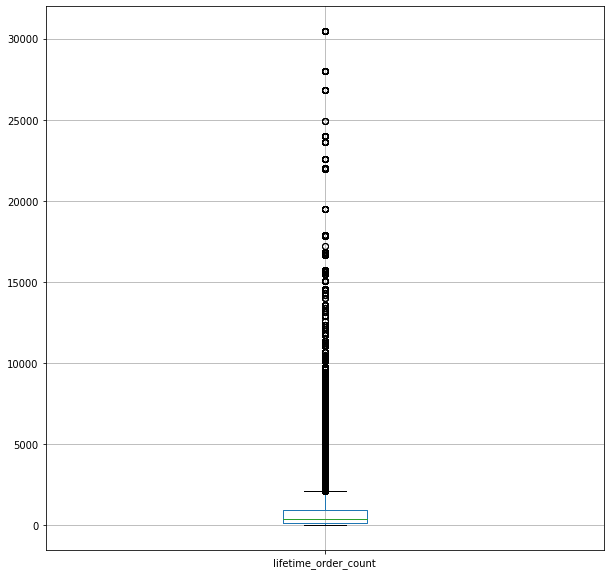

In [10]:
x = data_df[~np.isnan(data_df.lifetime_order_count)].lifetime_order_count.quantile(1)
plt.figure(figsize = (10,10))
data_df[~np.isnan(data_df.lifetime_order_count)][['lifetime_order_count']][data_df[~np.isnan(data_df.lifetime_order_count)][['lifetime_order_count']] <= x].boxplot(column = ['lifetime_order_count'])

<AxesSubplot:>

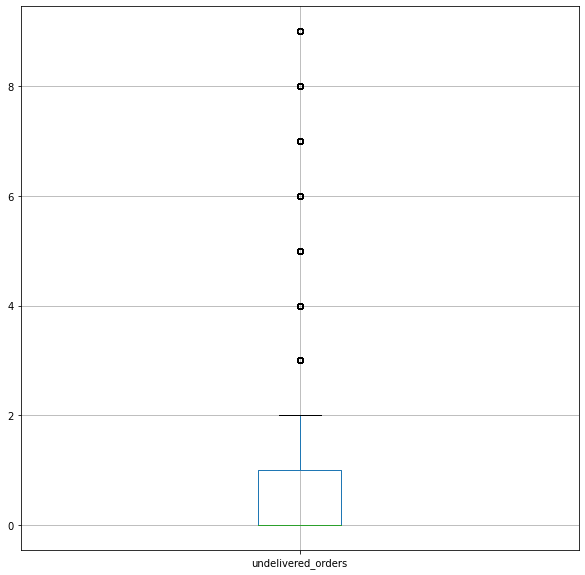

In [11]:
x = data_df[~np.isnan(data_df.undelivered_orders)].undelivered_orders.quantile(1)
plt.figure(figsize = (10,10))
data_df[~np.isnan(data_df.undelivered_orders)][['undelivered_orders']][data_df[~np.isnan(data_df.undelivered_orders)][['undelivered_orders']] <= x].boxplot(column = ['undelivered_orders'])

<AxesSubplot:>

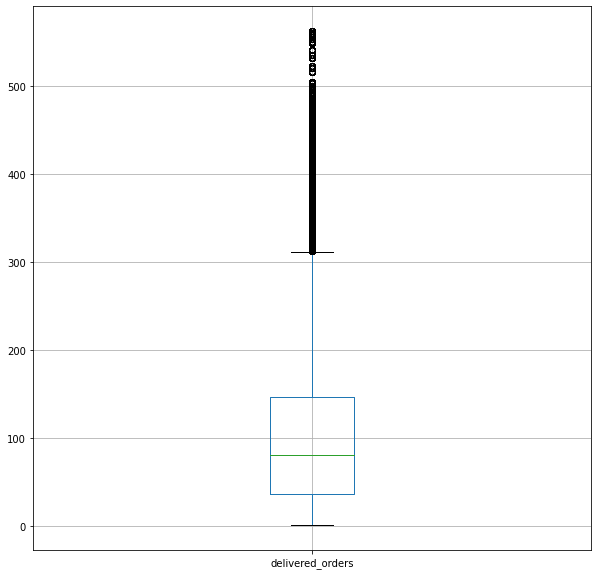

In [12]:
x = data_df[~np.isnan(data_df.delivered_orders)].delivered_orders.quantile(1)
plt.figure(figsize = (10,10))
data_df[~np.isnan(data_df.delivered_orders)][['delivered_orders']][data_df[~np.isnan(data_df.delivered_orders)][['delivered_orders']] <= x].boxplot(column = ['delivered_orders'])

<AxesSubplot:>

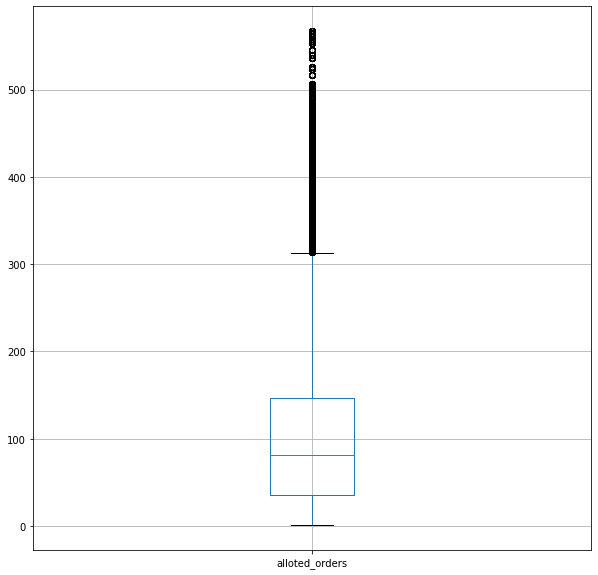

In [13]:
#alloted_orders
x = data_df[~np.isnan(data_df.alloted_orders)].alloted_orders.quantile(1)
plt.figure(figsize = (10,10))
data_df[~np.isnan(data_df.alloted_orders)][['alloted_orders']][data_df[~np.isnan(data_df.alloted_orders)][['alloted_orders']] <= x].boxplot(column = ['alloted_orders'])

In [14]:
def get_features(df ,test = False ,normalize = False):
    if test :
        df = df[['order_time','order_id','allot_time','accept_time','first_mile_distance', 'last_mile_distance','alloted_orders', 'delivered_orders', 'undelivered_orders','lifetime_order_count' ,'session_time' ,'reassigned_order']]
    else:    
        df = df[['order_time','allot_time','accept_time','first_mile_distance', 'last_mile_distance','alloted_orders', 'delivered_orders', 'undelivered_orders','lifetime_order_count' , 'session_time','reassigned_order']]
    days = ['Monday' , 'Saturday' , 'Sunday' , 'Thursday' , 'Tuesday', 'Wednesday' ,'Friday']
    for i in df.columns[5:]:
        #print(i)
        #print(df[[i]][~np.isnan(df[i])][i].quantile(0.5))
        if i == 'reassigned_order':
            df[[i]] = df[[i]].fillna(0)
            continue
        df[[i]] = df[[i]].fillna(df[[i]][~np.isnan(df[i])][i].quantile(0.5) )
    ## Processing Date 
    df.order_time = pd.to_datetime(df.order_time ,yearfirst =True)
    df.allot_time = pd.to_datetime(df.allot_time ,yearfirst =True)
    df.accept_time = pd.to_datetime(df.accept_time ,yearfirst =True)
    df['elapse1'] = (df.allot_time - df.order_time).dt.total_seconds()
    df['elapse2'] = (df.accept_time - df.allot_time).dt.total_seconds()
    df['elapse3'] = df['elapse1'] + df['elapse2']
    df[['elapse1']] = df[['elapse1']].fillna(df[['elapse1']][~np.isnan(df['elapse1'])]['elapse1'].quantile(0.5) )
    df[['elapse2']] = df[['elapse2']].fillna(df[['elapse2']][~np.isnan(df['elapse2'])]['elapse2'].quantile(0.5) )
    df[['elapse3']] = df[['elapse3']].fillna(df[['elapse3']][~np.isnan(df['elapse3'])]['elapse3'].quantile(0.5) )
    df['elapse4'] = df['elapse2']/df['elapse1']
    df['tot_dist'] = df['first_mile_distance'] + df['last_mile_distance']
    df['del_ratio'] = df['delivered_orders']/df['alloted_orders']
    df['order_ratio'] = df['alloted_orders']/df['lifetime_order_count']
    df['diff_dist'] = df['first_mile_distance'] - df['last_mile_distance']
    df['dist_ratio'] = df['first_mile_distance']/df['last_mile_distance']
    #df[['dist_ratio']] = df[['dist_ratio']].astype(np.float16)
    df['dist_ratio_2'] = df['last_mile_distance']/df['first_mile_distance']
    df['Day_of_the_week'] = df.order_time.dt.day_name()
    df['Hour'] = df.order_time.dt.hour
    df['Month'] = df.order_time.dt.month
    df.drop(columns = ['order_time'] ,inplace =True)
    df = pd.concat([df,pd.get_dummies(df['Day_of_the_week']).astype(int)] ,axis = 1)
    df.drop(columns = [ 'Day_of_the_week' ,'allot_time' , 'accept_time'] ,inplace = True) #'Day_of_the_week' ,
    for i in days:
        if i not in df.columns:
            df[i] = 0
    if normalize:
        df[['first_mile_distance','elapse1','elapse2', 'last_mile_distance','tot_dist','alloted_orders', 'delivered_orders','del_ratio','undelivered_orders','lifetime_order_count','Hour','session_time','dist_ratio']] = StandardScaler().fit_transform(df[['first_mile_distance','elapse1','elapse2', 'last_mile_distance','tot_dist','alloted_orders', 'delivered_orders','del_ratio','undelivered_orders','lifetime_order_count','Hour','session_time','dist_ratio']])
    if test:        
        df = df[['order_id','first_mile_distance','elapse1','elapse2', 'last_mile_distance','tot_dist','alloted_orders', 'delivered_orders','del_ratio','undelivered_orders','lifetime_order_count','Hour','session_time','Monday' , 'Saturday' , 'Sunday' , 'Thursday' , 'Tuesday', 'Wednesday','dist_ratio']]   #'Monday' , 'Saturday' , 'Sunday' , 'Thursday' , 'Tuesday', 'Wednesday'
    else:
        df = df[['first_mile_distance','elapse1','elapse2', 'last_mile_distance','tot_dist','alloted_orders', 'delivered_orders','del_ratio','undelivered_orders','lifetime_order_count','Hour','session_time','Monday' , 'Saturday' , 'Sunday' , 'Thursday' , 'Tuesday', 'Wednesday','dist_ratio']] #'undelivered_orders'  #,'del_ratio'  #,'order_ratio' #,'order_ratio' #,'diff_dist' #,'reassigned_order'#,'dist_ratio_2'#,'Hour'#,'Month'#,'tot_dist'
    df = reduce_mem_usage(df)
    return df

In [15]:
X ,y = get_features(data_df) , data_df[['cancelled']]
test_df = get_features(test_df ,test =True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

Memory usage of dataframe is 39.48 MB
Memory usage after optimization is: 18.88 MB
Decreased by 52.2%


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

Memory usage of dataframe is 13.26 MB
Memory usage after optimization is: 6.63 MB
Decreased by 50.0%


In [16]:
X.shape ,y.shape ,test_df.shape

((450000, 19), (450000, 1), (144844, 20))

In [17]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450000 entries, 0 to 449999
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   first_mile_distance   450000 non-null  float16
 1   elapse1               450000 non-null  float16
 2   elapse2               450000 non-null  float16
 3   last_mile_distance    450000 non-null  float16
 4   tot_dist              450000 non-null  float16
 5   alloted_orders        450000 non-null  float16
 6   delivered_orders      450000 non-null  float16
 7   del_ratio             450000 non-null  float16
 8   undelivered_orders    450000 non-null  float16
 9   lifetime_order_count  450000 non-null  float16
 10  Hour                  450000 non-null  int16  
 11  session_time          450000 non-null  float16
 12  Monday                450000 non-null  int16  
 13  Saturday              450000 non-null  int16  
 14  Sunday                450000 non-null  int16  
 15  

In [18]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450000 entries, 0 to 449999
Data columns (total 1 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   cancelled  450000 non-null  int16
dtypes: int16(1)
memory usage: 879.0 KB


In [19]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144844 entries, 0 to 144843
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              144844 non-null  int32  
 1   first_mile_distance   144844 non-null  float16
 2   elapse1               144844 non-null  float16
 3   elapse2               144844 non-null  float16
 4   last_mile_distance    144844 non-null  float16
 5   tot_dist              144844 non-null  float16
 6   alloted_orders        144844 non-null  float16
 7   delivered_orders      144844 non-null  float16
 8   del_ratio             144844 non-null  float16
 9   undelivered_orders    144844 non-null  float16
 10  lifetime_order_count  144844 non-null  float16
 11  Hour                  144844 non-null  int16  
 12  session_time          144844 non-null  float16
 13  Monday                144844 non-null  int16  
 14  Saturday              144844 non-null  int16  
 15  

In [20]:
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier

In [21]:
Length = X.shape[0]
X_train ,y_train = X[:int((1-TEST_SPLIT_RATIO)*Length)] , y[:int((1-TEST_SPLIT_RATIO)*Length)]
X_test , y_test = X[int((1-TEST_SPLIT_RATIO)*Length):] ,y[int((1-TEST_SPLIT_RATIO)*Length):]

In [22]:
import optuna
from optuna import Trial
from sklearn.model_selection import StratifiedKFold
print(optuna.__version__)
import gc
import warnings
warnings.filterwarnings("ignore")
from optuna.integration import LightGBMPruningCallback

2.10.0


In [23]:
def create_X_y(train_df):
    target_train_df = train_df
    #target_train_df =target_train_df.sample(frac =0.3)
    target_train_df = target_train_df.groupby('cancelled').apply(lambda x: x.sample(frac=1))
    print(f"cancelled :{target_train_df[target_train_df['cancelled'] == 1].shape[0]} , not_cancelled :{target_train_df[target_train_df['cancelled'] == 0].shape[0]}")
    X_train = get_features(target_train_df)
    X_train.reset_index(level=[0] ,inplace  =True)
    X_train.drop(columns = ['cancelled'] ,inplace =True)
    print(f"Features : {list(X_train.columns)}")
    y_train = target_train_df['cancelled'].values
    del target_train_df
    return X_train, y_train

In [24]:
def objective(trial: Trial):
    folds = 5
    seed = SEED
    shuffle = True
    kf = StratifiedKFold(n_splits=folds, shuffle=shuffle, random_state=seed)

    X_train, y_train = create_X_y(data_df)
    y_valid_pred_total = np.zeros(X_train.shape[0])
    gc.collect()

    #cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
    cat_features = []
    print('cat_features', cat_features)
    print(X_train.shape, y_train.shape)
    models = []
    valid_score = 0
    for train_idx, valid_idx in kf.split(X_train, y_train):
        train_data = X_train.iloc[train_idx,:], y_train[train_idx]
        valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

        print('train', len(train_idx), 'valid', len(valid_idx))
        model, log = fit_lgbm(trial, train_data, valid_data)
        models.append(model)
        gc.collect()
        valid_score += log["valid/roc_auc"]
    valid_score /= len(models)
    return valid_score

In [25]:
def fit_lgbm(trial, train, val, devices=(-1,), seed=SEED):
    """Train Light gbm model"""
    X_train, y_train = train
    X_valid, y_valid = val
    #metric = 'None'
    params = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [10000 ,15000 ,20000]),
        #"boosting": trial.suggest_categorical("boostng", ['gbdt' ,'rf' ,'dart']),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=1),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=50),
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 100),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100 ,step = 5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step =0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95 ,step =0.1
        ),
    }
    ##params = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
      #  "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        #"boosting": trial.suggest_categorical("boostng", ['gbdt' ,'rf' ,'dart']),
      #  "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
      #  "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
      #  "max_depth": trial.suggest_int("max_depth", 3, 12),
     #   "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
     #   "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 100),
     #   "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
     #   "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
     #   "bagging_fraction": trial.suggest_float(
      #      "bagging_fraction", 0.2, 0.95, step=0.1
     #   ),
     #   "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
     #   "feature_fraction": trial.suggest_float(
      #      "feature_fraction", 0.2, 0.95, step=0.1
      #  ),
   # }
    device = devices[0]
    if device == -1:
        # use cpu
        pass
    else:
        # use gpu
        print(f'using gpu device_id {device}...')
        params.update({'device': 'gpu', 'gpu_device_id': device})

    params['seed'] = seed
    #params['device'] = 'gpu'
    print('training Light GBM:')
    model = LGBMClassifier(objective = 'binary',**params).fit(X_train,y_train,
            eval_set=[(X_valid, y_valid)],
            eval_metric="binary_logloss",
            early_stopping_rounds=20,
            callbacks=[
                LightGBMPruningCallback(trial, "binary_logloss")
            ], )

    # predictions
    #print(f"shape of predict_proba = {model.predict_proba(val[0]).shape}")
    #print(model.predict_proba(val[0])[:5 ,...])
    y_pred_valid = -roc_auc_score(val[1], model.predict_proba(val[0])[:, 1])
    
    print('score', y_pred_valid)
    log = {'valid/roc_auc': y_pred_valid}
    return model, log

In [26]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=300)

[I 2022-02-11 10:07:25,081] A new study created in memory with name: no-name-c2ff5f39-46e5-4841-bb87-cbef01f21fb0


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=2.9395938677181945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9395938677181945
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=9.427493703767057, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.427493703767057
[LightGBM] [Warning] lambda_l2 is set=90, reg_

[I 2022-02-11 10:07:41,133] Trial 0 finished with value: -0.7318063112245832 and parameters: {'n_estimators': 15000, 'learning_rate': 0.261628646326651, 'num_leaves': 2948, 'max_depth': 9, 'min_data_in_leaf': 5350, 'lambda_l1': 2.9395938677181945, 'lambda_l2': 90, 'min_gain_to_split': 9.427493703767057, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 0 with value: -0.7318063112245832.


score -0.7216102866043034
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=22.034377483931177, reg_alpha=0.0 will be ignored. Current value: lambda_l1=22.034377483931177
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=12.945041660870247, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.945041660870247
[LightGBM] [Warning] lambda_l2 is set=80, reg_lamb

[I 2022-02-11 10:07:58,256] Trial 1 finished with value: -0.7281546156568599 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18827066896719202, 'num_leaves': 126, 'max_depth': 9, 'min_data_in_leaf': 9800, 'lambda_l1': 22.034377483931177, 'lambda_l2': 80, 'min_gain_to_split': 12.945041660870247, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 0 with value: -0.7318063112245832.


score -0.7385236323300046
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=1.788180353652817e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.788180353652817e-06
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=2.666773201410111, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.666773201410111
[LightGBM] [Warning] lambda_l2 is set=25, reg_

[I 2022-02-11 10:08:20,946] Trial 2 finished with value: -0.7388699031755597 and parameters: {'n_estimators': 20000, 'learning_rate': 0.30690969114588484, 'num_leaves': 797, 'max_depth': 6, 'min_data_in_leaf': 8650, 'lambda_l1': 1.788180353652817e-06, 'lambda_l2': 25, 'min_gain_to_split': 2.666773201410111, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 2 with value: -0.7388699031755597.


score -0.7357456058176077
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.0008573449530522803, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008573449530522803
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=11.924671943447352, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.924671943447352
[LightGBM] [Warning] lambda_l2 is set=85, re

[I 2022-02-11 10:08:37,734] Trial 3 finished with value: -0.7362657193707612 and parameters: {'n_estimators': 20000, 'learning_rate': 0.1723570802342459, 'num_leaves': 2130, 'max_depth': 9, 'min_data_in_leaf': 3950, 'lambda_l1': 0.0008573449530522803, 'lambda_l2': 85, 'min_gain_to_split': 11.924671943447352, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 2 with value: -0.7388699031755597.


score -0.739716040251679
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=2.0750765005376879e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0750765005376879e-07
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=9.611682451615485, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.611682451615485
[LightGBM] [Warning] lambda_l2 is set=20, reg

[I 2022-02-11 10:08:53,042] Trial 4 finished with value: -0.737545984377286 and parameters: {'n_estimators': 10000, 'learning_rate': 0.405463613089095, 'num_leaves': 1935, 'max_depth': 3, 'min_data_in_leaf': 4400, 'lambda_l1': 2.0750765005376879e-07, 'lambda_l2': 20, 'min_gain_to_split': 9.611682451615485, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 2 with value: -0.7388699031755597.


score -0.7474134183863597
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=7.081463116431042e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.081463116431042e-07
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=12.775742937799253, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.775742937799253
[LightGBM] [Warning] lambda_l2 is set=75, re

[I 2022-02-11 10:09:07,969] Trial 5 finished with value: -0.7409767869868341 and parameters: {'n_estimators': 15000, 'learning_rate': 0.29624387595283214, 'num_leaves': 923, 'max_depth': 11, 'min_data_in_leaf': 2500, 'lambda_l1': 7.081463116431042e-07, 'lambda_l2': 75, 'min_gain_to_split': 12.775742937799253, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 5 with value: -0.7409767869868341.


score -0.7358940820800983
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=3.4408455847921168e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4408455847921168e-06
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=11.724672581729454, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.724672581729454
[LightGBM] [Warning] lambda_l2 is set=0, r

[I 2022-02-11 10:09:21,362] Trial 6 finished with value: -0.7375300264814666 and parameters: {'n_estimators': 10000, 'learning_rate': 0.37189935338299984, 'num_leaves': 316, 'max_depth': 3, 'min_data_in_leaf': 5250, 'lambda_l1': 3.4408455847921168e-06, 'lambda_l2': 0, 'min_gain_to_split': 11.724672581729454, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 5 with value: -0.7409767869868341.


score -0.7332725214876562
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.0018619354964509306, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0018619354964509306
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=4.803402417780701, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.803402417780701
[LightGBM] [Warning] lambda_l2 is set=25, reg_

[I 2022-02-11 10:09:25,068] Trial 7 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
score -0.7470954623589187
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.5073946430169506, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5073946430169506
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=3.4810404448614998, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.4810404448614998
[Ligh

[I 2022-02-11 10:09:45,412] Trial 8 finished with value: -0.7471360800724142 and parameters: {'n_estimators': 10000, 'learning_rate': 0.33263901088758024, 'num_leaves': 107, 'max_depth': 6, 'min_data_in_leaf': 1650, 'lambda_l1': 0.5073946430169506, 'lambda_l2': 80, 'min_gain_to_split': 3.4810404448614998, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 8 with value: -0.7471360800724142.


score -0.7477545078465758
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=30.233275654740176, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30.233275654740176
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=6.052993701357364, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.052993701357364
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda

[I 2022-02-11 10:09:49,959] Trial 9 pruned. Trial was pruned at iteration 80.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:09:54,393] Trial 10 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
score -0.7541577366534646
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.0003510369960623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003510369960623
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=3.3508528024559574, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.3508528024559574
[Ligh

[I 2022-02-11 10:10:09,750] Trial 11 finished with value: -0.7464450992732343 and parameters: {'n_estimators': 15000, 'learning_rate': 0.47918222898614427, 'num_leaves': 554, 'max_depth': 12, 'min_data_in_leaf': 1550, 'lambda_l1': 0.0003510369960623, 'lambda_l2': 65, 'min_gain_to_split': 3.3508528024559574, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 8 with value: -0.7471360800724142.


score -0.737313150769445
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.0004189783112879489, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004189783112879489
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=2.941832404211504, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.941832404211504
[LightGBM] [Warni

[I 2022-02-11 10:10:23,406] Trial 12 finished with value: -0.7439166120412066 and parameters: {'n_estimators': 15000, 'learning_rate': 0.4996114497532257, 'num_leaves': 485, 'max_depth': 7, 'min_data_in_leaf': 650, 'lambda_l1': 0.0004189783112879489, 'lambda_l2': 60, 'min_gain_to_split': 2.941832404211504, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 8 with value: -0.7471360800724142.


score -0.7371256899316878
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.09782791176686033, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09782791176686033
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=0.2033502940242231, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2033502940242231
[LightGBM] [Warnin

[I 2022-02-11 10:10:37,131] Trial 13 finished with value: -0.7430324958367724 and parameters: {'n_estimators': 15000, 'learning_rate': 0.4833307144077918, 'num_leaves': 72, 'max_depth': 11, 'min_data_in_leaf': 2350, 'lambda_l1': 0.09782791176686033, 'lambda_l2': 65, 'min_gain_to_split': 0.2033502940242231, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 8 with value: -0.7471360800724142.


score -0.7391746925037115
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=3.8074388735804805e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8074388735804805e-05
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=3.2803126183652314, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2803126183652314
[LightGBM] [Warning] lambda_l2 is set=100,

[I 2022-02-11 10:10:52,732] Trial 14 finished with value: -0.7488949116636858 and parameters: {'n_estimators': 20000, 'learning_rate': 0.3572578915923442, 'num_leaves': 511, 'max_depth': 5, 'min_data_in_leaf': 1900, 'lambda_l1': 3.8074388735804805e-05, 'lambda_l2': 100, 'min_gain_to_split': 3.2803126183652314, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 14 with value: -0.7488949116636858.


score -0.7393024354974065
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=1.7098414247902e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7098414247902e-08
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=6.267238751109485, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.267238751109485
[LightGBM] [Warning] lambda_l2 is set=100, reg_lam

[I 2022-02-11 10:11:07,817] Trial 15 finished with value: -0.7461155556533032 and parameters: {'n_estimators': 20000, 'learning_rate': 0.35813965496442873, 'num_leaves': 1362, 'max_depth': 5, 'min_data_in_leaf': 3150, 'lambda_l1': 1.7098414247902e-08, 'lambda_l2': 100, 'min_gain_to_split': 6.267238751109485, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 14 with value: -0.7488949116636858.


score -0.7450966492281086
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=3.9181696699813925e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9181696699813925e-05
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=8.185468538758462, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.185468538758462
[LightGBM] [Warning] lambda_l2 is set=100, r

[I 2022-02-11 10:11:11,686] Trial 16 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
score -0.7432696618555438
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.018899056030119866, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.018899056030119866
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=1.8842885047545233, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8842885047545233
[

[I 2022-02-11 10:11:27,294] Trial 17 finished with value: -0.7448300215143429 and parameters: {'n_estimators': 20000, 'learning_rate': 0.3432524970736856, 'num_leaves': 20, 'max_depth': 7, 'min_data_in_leaf': 6650, 'lambda_l1': 0.018899056030119866, 'lambda_l2': 40, 'min_gain_to_split': 1.8842885047545233, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 14 with value: -0.7488949116636858.


score -0.7558939337007455
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.5300835497052954, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5300835497052954
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=14.794701488417177, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.794701488417177
[LightGBM] [Warning]

[I 2022-02-11 10:11:31,122] Trial 18 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
score -0.7590761934372484
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.019070980814924064, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.019070980814924064
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=4.505452758733763, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.505452758733763
[Li

[I 2022-02-11 10:11:43,487] Trial 19 finished with value: -0.7470750507881191 and parameters: {'n_estimators': 10000, 'learning_rate': 0.4075529605341134, 'num_leaves': 2794, 'max_depth': 8, 'min_data_in_leaf': 250, 'lambda_l1': 0.019070980814924064, 'lambda_l2': 70, 'min_gain_to_split': 4.505452758733763, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 14 with value: -0.7488949116636858.


score -0.7509973073777574
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=2.3138439736563383e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3138439736563383e-05
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=1.8033608765788518, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8033608765788518
[LightGBM] [Warning] lambda_l2 is set=100,

[I 2022-02-11 10:11:47,217] Trial 20 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
score -0.7433824745020192
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.007289908693224009, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007289908693224009
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=4.697267015937143, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.697267015937143
[Li

[I 2022-02-11 10:11:58,873] Trial 21 finished with value: -0.7450176164407039 and parameters: {'n_estimators': 10000, 'learning_rate': 0.4179077999922862, 'num_leaves': 2919, 'max_depth': 8, 'min_data_in_leaf': 300, 'lambda_l1': 0.007289908693224009, 'lambda_l2': 75, 'min_gain_to_split': 4.697267015937143, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 14 with value: -0.7488949116636858.


score -0.756558275872406
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=1.4560861519013482, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4560861519013482
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=4.168832153431536, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.168832153431536
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=

[I 2022-02-11 10:12:13,556] Trial 22 finished with value: -0.749546649288526 and parameters: {'n_estimators': 10000, 'learning_rate': 0.3188715054035669, 'num_leaves': 2575, 'max_depth': 8, 'min_data_in_leaf': 1150, 'lambda_l1': 1.4560861519013482, 'lambda_l2': 75, 'min_gain_to_split': 4.168832153431536, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 22 with value: -0.749546649288526.


score -0.7468813578076139
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=2.652145427693695, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.652145427693695
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=6.5780102649995795, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.5780102649995795
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda

[I 2022-02-11 10:12:17,440] Trial 23 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:12:21,487] Trial 24 pruned. Trial was pruned at iteration 12.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:12:25,364] Trial 25 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:12:29,316] Trial 26 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:12:33,327] Trial 27 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:12:37,179] Trial 28 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:12:41,106] Trial 29 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:12:45,092] Trial 30 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
score -0.7555663534896923
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.03558126144675695, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03558126144675695
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=4.639640713432928, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.639640713432928
[Ligh

[I 2022-02-11 10:12:59,313] Trial 31 finished with value: -0.7490168031034978 and parameters: {'n_estimators': 10000, 'learning_rate': 0.39167460819318917, 'num_leaves': 2986, 'max_depth': 8, 'min_data_in_leaf': 1050, 'lambda_l1': 0.03558126144675695, 'lambda_l2': 70, 'min_gain_to_split': 4.639640713432928, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 22 with value: -0.749546649288526.


score -0.7505827173759674
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.5457206353193202, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5457206353193202
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=5.225364453259594, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.225364453259594
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda

[I 2022-02-11 10:13:11,270] Trial 32 pruned. Trial was pruned at iteration 124.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:13:15,192] Trial 33 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:13:19,125] Trial 34 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:13:23,124] Trial 35 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:13:27,097] Trial 36 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:13:30,972] Trial 37 pruned. Trial was pruned at iteration 5.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:13:34,892] Trial 38 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:13:38,818] Trial 39 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:13:42,619] Trial 40 pruned. Trial was pruned at iteration 2.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
score -0.7664160588387308
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.018186887926473168, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.018186887926473168
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=4.821867728611187, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.821867728611187
[Li

[I 2022-02-11 10:13:55,390] Trial 41 finished with value: -0.7459652793516449 and parameters: {'n_estimators': 10000, 'learning_rate': 0.4070878816662888, 'num_leaves': 2594, 'max_depth': 8, 'min_data_in_leaf': 450, 'lambda_l1': 0.018186887926473168, 'lambda_l2': 70, 'min_gain_to_split': 4.821867728611187, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 22 with value: -0.749546649288526.


score -0.7506583337769639
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.025056551286175087, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.025056551286175087
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=4.457794558850232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.457794558850232
[LightGBM] [Warning] lambda_l2 is set=0, reg_lam

[I 2022-02-11 10:13:59,118] Trial 42 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
score -0.7486700055056926
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.0011902253357034653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0011902253357034653
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=3.3214893514774637, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.3214893514774637

[I 2022-02-11 10:14:13,320] Trial 43 finished with value: -0.7495685788857203 and parameters: {'n_estimators': 10000, 'learning_rate': 0.35478443343077803, 'num_leaves': 2761, 'max_depth': 9, 'min_data_in_leaf': 1550, 'lambda_l1': 0.0011902253357034653, 'lambda_l2': 55, 'min_gain_to_split': 3.3214893514774637, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 43 with value: -0.7495685788857203.


score -0.7341453754139762
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.00013387024367316107, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013387024367316107
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=3.419458914434173, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.419458914434173
[LightGBM] [Warning] lambda_l2 is set=50, re

[I 2022-02-11 10:14:17,631] Trial 44 pruned. Trial was pruned at iteration 31.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:14:21,508] Trial 45 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:14:25,408] Trial 46 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:14:29,312] Trial 47 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:14:33,293] Trial 48 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:14:37,241] Trial 49 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:14:40,983] Trial 50 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:14:45,377] Trial 51 pruned. Trial was pruned at iteration 25.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
score -0.7561264666088632
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.0565916445213246, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0565916445213246
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=5.1356679841579105, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.1356679841579105
[Ligh

[I 2022-02-11 10:14:58,688] Trial 52 finished with value: -0.7474185646299979 and parameters: {'n_estimators': 10000, 'learning_rate': 0.374634500723726, 'num_leaves': 2855, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 0.0565916445213246, 'lambda_l2': 70, 'min_gain_to_split': 5.1356679841579105, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 43 with value: -0.7495685788857203.


score -0.7439216581136414
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.07978032174531406, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07978032174531406
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=5.286922486434888, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.286922486434888
[LightGBM] [Warning] lambda_l2 is set=80, reg_lamb

[I 2022-02-11 10:15:02,955] Trial 53 pruned. Trial was pruned at iteration 29.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:15:06,690] Trial 54 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:15:10,465] Trial 55 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:15:14,398] Trial 56 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:15:18,202] Trial 57 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:15:22,135] Trial 58 pruned. Trial was pruned at iteration 6.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
score -0.7579181905364535
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.9515871233638558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9515871233638558
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=7.37483799416558, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.37483799416558
[LightGBM

[I 2022-02-11 10:15:33,413] Trial 59 finished with value: -0.747319798413187 and parameters: {'n_estimators': 10000, 'learning_rate': 0.32768666412002323, 'num_leaves': 2043, 'max_depth': 5, 'min_data_in_leaf': 2300, 'lambda_l1': 0.9515871233638558, 'lambda_l2': 30, 'min_gain_to_split': 7.37483799416558, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 43 with value: -0.7495685788857203.


score -0.7368707207954546
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=9.739984998175546e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.739984998175546e-05
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=8.96927640739159, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.96927640739159
[LightGBM] [Warning] lambda_l2 is set=30, reg_la

[I 2022-02-11 10:15:47,158] Trial 60 finished with value: -0.7454250355502692 and parameters: {'n_estimators': 10000, 'learning_rate': 0.27097673272501765, 'num_leaves': 2060, 'max_depth': 5, 'min_data_in_leaf': 2300, 'lambda_l1': 9.739984998175546e-05, 'lambda_l2': 30, 'min_gain_to_split': 8.96927640739159, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 43 with value: -0.7495685788857203.


score -0.7523898013034642
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.8936218887395236, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8936218887395236
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=10.612302856223522, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.612302856223522
[LightGBM] [Warning] lambda_l2 is set=10, reg_lamb

[I 2022-02-11 10:15:51,389] Trial 61 pruned. Trial was pruned at iteration 37.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
score -0.7566348618065558
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=2.5180554301838067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5180554301838067
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=7.586437060334413, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.586437060334413
[LightG

[I 2022-02-11 10:16:03,675] Trial 62 finished with value: -0.7475037985660176 and parameters: {'n_estimators': 10000, 'learning_rate': 0.32786330702432015, 'num_leaves': 2746, 'max_depth': 5, 'min_data_in_leaf': 550, 'lambda_l1': 2.5180554301838067, 'lambda_l2': 25, 'min_gain_to_split': 7.586437060334413, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 43 with value: -0.7495685788857203.


score -0.7467729644290975
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=1.9650027134230101, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9650027134230101
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=7.902565610793949, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.902565610793949
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda

[I 2022-02-11 10:16:07,817] Trial 63 pruned. Trial was pruned at iteration 26.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:16:11,790] Trial 64 pruned. Trial was pruned at iteration 12.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:16:16,093] Trial 65 pruned. Trial was pruned at iteration 36.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
score -0.7436635307150834
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.003527079702400713, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003527079702400713
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=8.74806937096882, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.74806937096882
[Ligh

[I 2022-02-11 10:16:29,135] Trial 66 finished with value: -0.7488540793776022 and parameters: {'n_estimators': 10000, 'learning_rate': 0.25217091067346253, 'num_leaves': 1739, 'max_depth': 8, 'min_data_in_leaf': 650, 'lambda_l1': 0.003527079702400713, 'lambda_l2': 15, 'min_gain_to_split': 8.74806937096882, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 43 with value: -0.7495685788857203.


score -0.7411799726981991
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.00496043704594247, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00496043704594247
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=8.56852111775244, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.56852111775244
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=

[I 2022-02-11 10:16:33,167] Trial 67 pruned. Trial was pruned at iteration 14.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:16:36,982] Trial 68 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
score -0.7450316548492177
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.010733478549043428, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010733478549043428
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=11.071945184639057, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.071945184639057
[

[I 2022-02-11 10:16:49,075] Trial 69 finished with value: -0.7443448920264112 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23742794980456883, 'num_leaves': 2803, 'max_depth': 9, 'min_data_in_leaf': 1500, 'lambda_l1': 0.010733478549043428, 'lambda_l2': 15, 'min_gain_to_split': 11.071945184639057, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 43 with value: -0.7495685788857203.


score -0.7291150084703291
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.0001920423638658969, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001920423638658969
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=9.839504370177577, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.839504370177577
[LightGBM] [Warning] lambda_l2 is set=10, reg_

[I 2022-02-11 10:16:53,055] Trial 70 pruned. Trial was pruned at iteration 11.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:16:57,379] Trial 71 pruned. Trial was pruned at iteration 35.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
score -0.746430064980925
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.22576818814669308, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22576818814669308
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=8.401762937743962, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.401762937743962
[Light

[I 2022-02-11 10:17:09,702] Trial 72 finished with value: -0.7467281072574199 and parameters: {'n_estimators': 10000, 'learning_rate': 0.27118915970011337, 'num_leaves': 1638, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 0.22576818814669308, 'lambda_l2': 20, 'min_gain_to_split': 8.401762937743962, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 43 with value: -0.7495685788857203.


score -0.747613079064961
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.8012444722910134, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8012444722910134
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=9.9663443417464, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.9663443417464
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 

[I 2022-02-11 10:17:14,518] Trial 73 pruned. Trial was pruned at iteration 3.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
score -0.7594120608391587
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.011308842591637535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011308842591637535
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=8.992383084300583, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.992383084300583
[Li

[I 2022-02-11 10:17:28,113] Trial 74 finished with value: -0.7439333629039636 and parameters: {'n_estimators': 10000, 'learning_rate': 0.3542911097888193, 'num_leaves': 2142, 'max_depth': 7, 'min_data_in_leaf': 2100, 'lambda_l1': 0.011308842591637535, 'lambda_l2': 70, 'min_gain_to_split': 8.992383084300583, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 43 with value: -0.7495685788857203.


score -0.7396631706854429
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.04839157576958098, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04839157576958098
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=6.879575808677421, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.879575808677421
[LightGBM] [Warning] lambda_l2 is set=30, reg_lamb

[I 2022-02-11 10:17:32,182] Trial 75 pruned. Trial was pruned at iteration 7.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:17:36,157] Trial 76 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:17:40,053] Trial 77 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
score -0.7503342911289047
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.0008365801997471243, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008365801997471243
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=3.902311956584986, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.902311956584986
[

[I 2022-02-11 10:17:51,954] Trial 78 finished with value: -0.7467163552561661 and parameters: {'n_estimators': 10000, 'learning_rate': 0.4231598635868943, 'num_leaves': 2732, 'max_depth': 8, 'min_data_in_leaf': 450, 'lambda_l1': 0.0008365801997471243, 'lambda_l2': 20, 'min_gain_to_split': 3.902311956584986, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 43 with value: -0.7495685788857203.


score -0.7467235459211055
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.0029456373208787924, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0029456373208787924
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=4.520880639985292, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.520880639985292
[LightGBM] [Warning] lambda_l2 is set=55, reg_

[I 2022-02-11 10:17:55,838] Trial 79 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:17:59,786] Trial 80 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:18:03,647] Trial 81 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:18:07,500] Trial 82 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:18:11,220] Trial 83 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:18:14,995] Trial 84 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:18:18,959] Trial 85 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:18:22,749] Trial 86 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:18:26,582] Trial 87 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:18:30,328] Trial 88 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:18:34,125] Trial 89 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:18:38,008] Trial 90 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:18:41,862] Trial 91 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:18:45,737] Trial 92 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:18:49,621] Trial 93 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:18:53,429] Trial 94 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:18:57,387] Trial 95 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:19:01,302] Trial 96 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:19:05,284] Trial 97 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:19:09,265] Trial 98 pruned. Trial was pruned at iteration 5.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:19:13,170] Trial 99 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:19:16,952] Trial 100 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
score -0.7545044143242594
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.24473925592647927, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.24473925592647927
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=8.341401740760503, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.341401740760503
[Ligh

[I 2022-02-11 10:19:31,614] Trial 101 finished with value: -0.7467533953914841 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2693001768880286, 'num_leaves': 1618, 'max_depth': 8, 'min_data_in_leaf': 300, 'lambda_l1': 0.24473925592647927, 'lambda_l2': 20, 'min_gain_to_split': 8.341401740760503, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 43 with value: -0.7495685788857203.


score -0.7437543006323328
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.8539749181514373, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8539749181514373
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=7.2444853827654505, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.2444853827654505
[LightGBM] [Warning] lambda_l2 is set=25, reg_lamb

[I 2022-02-11 10:19:36,141] Trial 102 pruned. Trial was pruned at iteration 31.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:19:40,267] Trial 103 pruned. Trial was pruned at iteration 8.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:19:44,271] Trial 104 pruned. Trial was pruned at iteration 2.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:19:48,404] Trial 105 pruned. Trial was pruned at iteration 9.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:19:52,285] Trial 106 pruned. Trial was pruned at iteration 4.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:19:55,956] Trial 107 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:20:00,182] Trial 108 pruned. Trial was pruned at iteration 4.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:20:04,167] Trial 109 pruned. Trial was pruned at iteration 6.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:20:08,111] Trial 110 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
score -0.749681493157019
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.2095383100111254, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2095383100111254
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=8.654353927826206, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.654353927826206
[LightGB

[I 2022-02-11 10:20:20,047] Trial 111 finished with value: -0.7480778863081048 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2682279752318444, 'num_leaves': 1649, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 0.2095383100111254, 'lambda_l2': 20, 'min_gain_to_split': 8.654353927826206, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 43 with value: -0.7495685788857203.


score -0.7565917419848016
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=1.3385426937942748, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3385426937942748
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=8.148617953082276, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.148617953082276
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda

[I 2022-02-11 10:20:23,904] Trial 112 pruned. Trial was pruned at iteration 4.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:20:27,881] Trial 113 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:20:32,197] Trial 114 pruned. Trial was pruned at iteration 9.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
score -0.7459125678170577
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.04206878494709979, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04206878494709979
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=3.2850934500065705, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2850934500065705
[Li

[I 2022-02-11 10:20:46,982] Trial 115 finished with value: -0.7505066894232363 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2820060384288739, 'num_leaves': 2723, 'max_depth': 8, 'min_data_in_leaf': 1400, 'lambda_l1': 0.04206878494709979, 'lambda_l2': 20, 'min_gain_to_split': 3.2850934500065705, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 115 with value: -0.7505066894232363.


score -0.7576250781952729
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=3.597096027879891e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.597096027879891e-07
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=2.0607201330836196, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.0607201330836196
[LightGBM] [Warning] lambda_l2 is set=65, re

[I 2022-02-11 10:20:50,918] Trial 116 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:20:54,881] Trial 117 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
score -0.751673066945818
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.003064498617449944, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003064498617449944
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=3.6049024686795184, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.6049024686795184
[L

[I 2022-02-11 10:21:07,587] Trial 118 finished with value: -0.74790360368361 and parameters: {'n_estimators': 20000, 'learning_rate': 0.41414645861407484, 'num_leaves': 2749, 'max_depth': 9, 'min_data_in_leaf': 2150, 'lambda_l1': 0.003064498617449944, 'lambda_l2': 15, 'min_gain_to_split': 3.6049024686795184, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 115 with value: -0.7505066894232363.


score -0.7483282503175619
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.0034677411935446394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0034677411935446394
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=3.928550440118529, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.928550440118529
[LightGBM] [Warning] lambda_l2 is set=20, reg_

[I 2022-02-11 10:21:23,147] Trial 119 finished with value: -0.750851069493043 and parameters: {'n_estimators': 20000, 'learning_rate': 0.28262154348124036, 'num_leaves': 2610, 'max_depth': 9, 'min_data_in_leaf': 2100, 'lambda_l1': 0.0034677411935446394, 'lambda_l2': 20, 'min_gain_to_split': 3.928550440118529, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 119 with value: -0.750851069493043.


score -0.7541286985653418
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.0032200842931088733, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0032200842931088733
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=3.7789559875917047, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.7789559875917047
[LightGBM] [Warning] lambda_l2 is set=20, re

[I 2022-02-11 10:21:27,089] Trial 120 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:21:31,165] Trial 121 pruned. Trial was pruned at iteration 4.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:21:35,262] Trial 122 pruned. Trial was pruned at iteration 5.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
score -0.748238182147771
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.002117672351226509, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002117672351226509
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=3.4085611754731637, min_split_gain=0.0 will be ignored. Current value: min_gain_

[I 2022-02-11 10:21:49,644] Trial 123 finished with value: -0.7470728463317255 and parameters: {'n_estimators': 20000, 'learning_rate': 0.3081241269175692, 'num_leaves': 2740, 'max_depth': 9, 'min_data_in_leaf': 2150, 'lambda_l1': 0.002117672351226509, 'lambda_l2': 20, 'min_gain_to_split': 3.4085611754731637, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 119 with value: -0.750851069493043.


score -0.7279515926682252
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.007012016277843143, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007012016277843143
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=2.339259534210291, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.339259534210291
[LightGBM] [Warning] lambda_l2 is set=5, reg_lam

[I 2022-02-11 10:21:53,691] Trial 124 pruned. Trial was pruned at iteration 10.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:21:57,652] Trial 125 pruned. Trial was pruned at iteration 3.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:22:01,806] Trial 126 pruned. Trial was pruned at iteration 10.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:22:05,724] Trial 127 pruned. Trial was pruned at iteration 2.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:22:09,634] Trial 128 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:22:13,762] Trial 129 pruned. Trial was pruned at iteration 10.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
score -0.7537712399015194
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.0016118053526835419, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0016118053526835419
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=4.086007126863788, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.086007126863788
[

[I 2022-02-11 10:22:25,869] Trial 130 finished with value: -0.7458069106175074 and parameters: {'n_estimators': 20000, 'learning_rate': 0.4115192266955661, 'num_leaves': 486, 'max_depth': 11, 'min_data_in_leaf': 2100, 'lambda_l1': 0.0016118053526835419, 'lambda_l2': 20, 'min_gain_to_split': 4.086007126863788, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 119 with value: -0.750851069493043.


score -0.7553448547208925
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=2.9989153260745023, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9989153260745023
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=5.0315714154328095, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.0315714154328095
[LightGBM] [Warning] lambda_l2 is set=15, reg_lamb

[I 2022-02-11 10:22:29,872] Trial 131 pruned. Trial was pruned at iteration 9.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:22:34,062] Trial 132 pruned. Trial was pruned at iteration 12.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
score -0.7588582689789116
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.06799932844805467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06799932844805467
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=4.428018943671857, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.428018943671857
[Ligh

[I 2022-02-11 10:22:48,686] Trial 133 finished with value: -0.7472666303380947 and parameters: {'n_estimators': 10000, 'learning_rate': 0.36570363094136704, 'num_leaves': 3000, 'max_depth': 8, 'min_data_in_leaf': 1200, 'lambda_l1': 0.06799932844805467, 'lambda_l2': 55, 'min_gain_to_split': 4.428018943671857, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 119 with value: -0.750851069493043.


score -0.735087627375814
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=1.0230234120998765e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0230234120998765e-08
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=3.8113531904281386, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8113531904281386
[LightGBM] [Warning] lambda_l2 is set=55, r

[I 2022-02-11 10:22:52,622] Trial 134 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:22:56,662] Trial 135 pruned. Trial was pruned at iteration 4.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:23:00,612] Trial 136 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:23:04,468] Trial 137 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
score -0.7512948530369812
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=1.1107931957727255, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1107931957727255
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=3.587018800630459, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.587018800630459
[LightG

[I 2022-02-11 10:23:19,509] Trial 138 finished with value: -0.75040917213074 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29665085367501964, 'num_leaves': 2996, 'max_depth': 8, 'min_data_in_leaf': 1700, 'lambda_l1': 1.1107931957727255, 'lambda_l2': 25, 'min_gain_to_split': 3.587018800630459, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 119 with value: -0.750851069493043.


score -0.7460341203167471
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=1.316307061133922, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.316307061133922
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=12.065454324904557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.065454324904557
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda

[I 2022-02-11 10:23:23,485] Trial 139 pruned. Trial was pruned at iteration 5.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:23:27,526] Trial 140 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:23:31,549] Trial 141 pruned. Trial was pruned at iteration 6.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
score -0.7604214737379822
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.4599959422677634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4599959422677634
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=3.5660700183349063, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5660700183349063
[Ligh

[I 2022-02-11 10:23:46,626] Trial 142 finished with value: -0.7509172918147142 and parameters: {'n_estimators': 10000, 'learning_rate': 0.32063862666747056, 'num_leaves': 2994, 'max_depth': 9, 'min_data_in_leaf': 1600, 'lambda_l1': 0.4599959422677634, 'lambda_l2': 25, 'min_gain_to_split': 3.5660700183349063, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 142 with value: -0.7509172918147142.


score -0.7636145701374772
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.0009374894518164766, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009374894518164766
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=3.570810073816754, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.570810073816754
[LightGBM] [Warning] lambda_l2 is set=25, reg_

[I 2022-02-11 10:23:50,606] Trial 143 pruned. Trial was pruned at iteration 3.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:23:54,605] Trial 144 pruned. Trial was pruned at iteration 3.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:23:58,665] Trial 145 pruned. Trial was pruned at iteration 3.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:24:02,849] Trial 146 pruned. Trial was pruned at iteration 9.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:24:06,664] Trial 147 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:24:10,578] Trial 148 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:24:14,887] Trial 149 pruned. Trial was pruned at iteration 23.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:24:18,774] Trial 150 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:24:22,633] Trial 151 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:24:26,441] Trial 152 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:24:30,454] Trial 153 pruned. Trial was pruned at iteration 6.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:24:34,410] Trial 154 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:24:38,187] Trial 155 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:24:42,221] Trial 156 pruned. Trial was pruned at iteration 12.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:24:46,054] Trial 157 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:24:49,997] Trial 158 pruned. Trial was pruned at iteration 6.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:24:53,845] Trial 159 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:24:57,659] Trial 160 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:25:01,628] Trial 161 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:25:05,529] Trial 162 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:25:09,269] Trial 163 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:25:13,188] Trial 164 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:25:17,082] Trial 165 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:25:20,920] Trial 166 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:25:25,186] Trial 167 pruned. Trial was pruned at iteration 9.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:25:29,113] Trial 168 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:25:33,020] Trial 169 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:25:36,769] Trial 170 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
score -0.7546468501253004
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.001767184191261159, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001767184191261159
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=3.4031481661229117, min_split_gain=0.0 will be ignored. Current value: min_gain

[I 2022-02-11 10:25:50,198] Trial 171 finished with value: -0.7477659034136706 and parameters: {'n_estimators': 20000, 'learning_rate': 0.3237384345213935, 'num_leaves': 2720, 'max_depth': 9, 'min_data_in_leaf': 2150, 'lambda_l1': 0.001767184191261159, 'lambda_l2': 20, 'min_gain_to_split': 3.4031481661229117, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 142 with value: -0.7509172918147142.


score -0.742009551107879
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.00213338089920136, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00213338089920136
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=3.214074556323522, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.214074556323522
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambd

[I 2022-02-11 10:25:54,238] Trial 172 pruned. Trial was pruned at iteration 3.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:25:58,196] Trial 173 pruned. Trial was pruned at iteration 3.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:26:02,148] Trial 174 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:26:06,326] Trial 175 pruned. Trial was pruned at iteration 16.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:26:10,276] Trial 176 pruned. Trial was pruned at iteration 3.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:26:14,263] Trial 177 pruned. Trial was pruned at iteration 6.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:26:18,081] Trial 178 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:26:21,896] Trial 179 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:26:25,788] Trial 180 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:26:30,076] Trial 181 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:26:34,073] Trial 182 pruned. Trial was pruned at iteration 3.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:26:38,452] Trial 183 pruned. Trial was pruned at iteration 21.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:26:42,384] Trial 184 pruned. Trial was pruned at iteration 2.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:26:46,324] Trial 185 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:26:50,155] Trial 186 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:26:54,072] Trial 187 pruned. Trial was pruned at iteration 3.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
score -0.7612053906790758
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=1.8018829690670024, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8018829690670024
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=4.344333424443881, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.344333424443881
[LightG

[I 2022-02-11 10:27:09,533] Trial 188 finished with value: -0.7523407399865851 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2523889555990624, 'num_leaves': 1586, 'max_depth': 9, 'min_data_in_leaf': 1450, 'lambda_l1': 1.8018829690670024, 'lambda_l2': 20, 'min_gain_to_split': 4.344333424443881, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 188 with value: -0.7523407399865851.


score -0.771309450158234
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=1.460940450333369, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.460940450333369
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=4.444032911014787, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.444032911014787
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.

[I 2022-02-11 10:27:13,405] Trial 189 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:27:18,001] Trial 190 pruned. Trial was pruned at iteration 10.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:27:22,552] Trial 191 pruned. Trial was pruned at iteration 2.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:27:28,563] Trial 192 pruned. Trial was pruned at iteration 10.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:27:32,786] Trial 193 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:27:36,736] Trial 194 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
score -0.7598483354842678
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.03499148395055527, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03499148395055527
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=2.5720656909033264, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.5720656909033264
[Li

[I 2022-02-11 10:27:50,016] Trial 195 finished with value: -0.7524194716556609 and parameters: {'n_estimators': 10000, 'learning_rate': 0.26278367829329163, 'num_leaves': 1741, 'max_depth': 9, 'min_data_in_leaf': 1400, 'lambda_l1': 0.03499148395055527, 'lambda_l2': 25, 'min_gain_to_split': 2.5720656909033264, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 195 with value: -0.7524194716556609.


score -0.7481830582134625
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.026655757592004548, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.026655757592004548
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=2.549429653964094, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.549429653964094
[LightGBM] [Warning] lambda_l2 is set=30, reg_la

[I 2022-02-11 10:27:53,862] Trial 196 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
score -0.7611854245543412
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.9742191379197725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9742191379197725
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=6.108990626390034, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.108990626390034
[LightG

[I 2022-02-11 10:28:06,372] Trial 197 finished with value: -0.7508032722784661 and parameters: {'n_estimators': 10000, 'learning_rate': 0.26162615116665233, 'num_leaves': 1522, 'max_depth': 8, 'min_data_in_leaf': 1500, 'lambda_l1': 0.9742191379197725, 'lambda_l2': 25, 'min_gain_to_split': 6.108990626390034, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 195 with value: -0.7524194716556609.


score -0.7577521697411557
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.8267457014190934, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8267457014190934
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=5.7018646973079985, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.7018646973079985
[LightGBM] [Warning] lambda_l2 is set=25, reg_lamb

[I 2022-02-11 10:28:10,490] Trial 198 pruned. Trial was pruned at iteration 3.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
score -0.7695819964337753
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=1.5262997693684974, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5262997693684974
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=6.447462103134479, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.447462103134479
[LightG

[I 2022-02-11 10:28:22,704] Trial 199 finished with value: -0.7491478771489405 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2748824952763669, 'num_leaves': 1594, 'max_depth': 9, 'min_data_in_leaf': 1500, 'lambda_l1': 1.5262997693684974, 'lambda_l2': 25, 'min_gain_to_split': 6.447462103134479, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 195 with value: -0.7524194716556609.


score -0.7604680879728909
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=1.5561828514133078, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5561828514133078
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=6.188889192697781, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.188889192697781
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda

[I 2022-02-11 10:28:26,598] Trial 200 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:28:30,633] Trial 201 pruned. Trial was pruned at iteration 3.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
score -0.752105973486215
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=2.2275143126018317, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2275143126018317
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=6.208244537319992, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.208244537319992
[LightGB

[I 2022-02-11 10:28:43,418] Trial 202 finished with value: -0.7495884050961668 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2726926436468864, 'num_leaves': 1682, 'max_depth': 9, 'min_data_in_leaf': 1600, 'lambda_l1': 2.2275143126018317, 'lambda_l2': 25, 'min_gain_to_split': 6.208244537319992, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 195 with value: -0.7524194716556609.


score -0.7469808355036776
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=4.331919504842715, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.331919504842715
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=5.937026889189696, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.937026889189696
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0

[I 2022-02-11 10:28:47,381] Trial 203 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:28:51,282] Trial 204 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:28:55,143] Trial 205 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:28:58,996] Trial 206 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:29:03,206] Trial 207 pruned. Trial was pruned at iteration 19.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:29:07,102] Trial 208 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
score -0.7464701858442578
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.9826184940114355, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9826184940114355
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=1.8795351148514803, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8795351148514803
[Ligh

[I 2022-02-11 10:29:23,142] Trial 209 finished with value: -0.7498861715699952 and parameters: {'n_estimators': 10000, 'learning_rate': 0.26142344976977555, 'num_leaves': 1338, 'max_depth': 9, 'min_data_in_leaf': 1650, 'lambda_l1': 0.9826184940114355, 'lambda_l2': 25, 'min_gain_to_split': 1.8795351148514803, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 195 with value: -0.7524194716556609.


score -0.7396985319187462
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.9706915056610403, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9706915056610403
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=1.8796308176718406, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8796308176718406
[LightGBM] [Warning] lambda_l2 is set=25, reg_lamb

[I 2022-02-11 10:29:27,075] Trial 210 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:29:31,287] Trial 211 pruned. Trial was pruned at iteration 12.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:29:35,215] Trial 212 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:29:39,365] Trial 213 pruned. Trial was pruned at iteration 8.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:29:43,303] Trial 214 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
score -0.752821752321737
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.03577867317626096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03577867317626096
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=8.903174554320541, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.903174554320541
[Light

[I 2022-02-11 10:29:56,271] Trial 215 finished with value: -0.7472758678868322 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2785160401112079, 'num_leaves': 1884, 'max_depth': 9, 'min_data_in_leaf': 1050, 'lambda_l1': 0.03577867317626096, 'lambda_l2': 20, 'min_gain_to_split': 8.903174554320541, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 195 with value: -0.7524194716556609.


score -0.7377157832043704
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.03717801690900929, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03717801690900929
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=8.115596868286225, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.115596868286225
[LightGBM] [Warning] lambda_l2 is set=20, reg_lamb

[I 2022-02-11 10:30:07,880] Trial 216 finished with value: -0.7461760545158485 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2786892136826675, 'num_leaves': 1774, 'max_depth': 9, 'min_data_in_leaf': 1800, 'lambda_l1': 0.03717801690900929, 'lambda_l2': 20, 'min_gain_to_split': 8.115596868286225, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 195 with value: -0.7524194716556609.


score -0.7462241492586891
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=1.1418810393007761, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1418810393007761
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=8.815445666559853, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.815445666559853
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda

[I 2022-02-11 10:30:11,779] Trial 217 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:30:15,909] Trial 218 pruned. Trial was pruned at iteration 12.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:30:19,820] Trial 219 pruned. Trial was pruned at iteration 2.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:30:23,789] Trial 220 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:30:27,748] Trial 221 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:30:31,606] Trial 222 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:30:35,579] Trial 223 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:30:39,442] Trial 224 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:30:43,574] Trial 225 pruned. Trial was pruned at iteration 12.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:30:47,522] Trial 226 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:30:51,323] Trial 227 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:30:55,306] Trial 228 pruned. Trial was pruned at iteration 3.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:30:59,343] Trial 229 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:31:03,259] Trial 230 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:31:07,131] Trial 231 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:31:10,967] Trial 232 pruned. Trial was pruned at iteration 3.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:31:14,922] Trial 233 pruned. Trial was pruned at iteration 7.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:31:19,014] Trial 234 pruned. Trial was pruned at iteration 7.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:31:22,803] Trial 235 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:31:27,106] Trial 236 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:31:30,984] Trial 237 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:31:34,899] Trial 238 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:31:38,775] Trial 239 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
score -0.7546498463912525
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.015735687158970668, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015735687158970668
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=4.123184978464687, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.123184978464687
[Li

[I 2022-02-11 10:31:52,188] Trial 240 finished with value: -0.7502002717645038 and parameters: {'n_estimators': 10000, 'learning_rate': 0.3592354957342792, 'num_leaves': 624, 'max_depth': 9, 'min_data_in_leaf': 1350, 'lambda_l1': 0.015735687158970668, 'lambda_l2': 10, 'min_gain_to_split': 4.123184978464687, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 195 with value: -0.7524194716556609.


score -0.7565455430288064
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.015470821051162363, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015470821051162363
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=4.138754670467945, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.138754670467945
[LightGBM] [Warning] lambda_l2 is set=5, reg_lam

[I 2022-02-11 10:31:56,123] Trial 241 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
score -0.7419973697311674
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.027890547230867015, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.027890547230867015
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=3.8044911700318993, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8044911700318993
[

[I 2022-02-11 10:32:08,582] Trial 242 finished with value: -0.7477445693251648 and parameters: {'n_estimators': 10000, 'learning_rate': 0.3484911992331807, 'num_leaves': 416, 'max_depth': 9, 'min_data_in_leaf': 1400, 'lambda_l1': 0.027890547230867015, 'lambda_l2': 10, 'min_gain_to_split': 3.8044911700318993, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 195 with value: -0.7524194716556609.


score -0.7422815924838816
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.030826644317482207, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.030826644317482207
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=3.9345948041875887, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.9345948041875887
[LightGBM] [Warning] lambda_l2 is set=10, reg_

[I 2022-02-11 10:32:12,742] Trial 243 pruned. Trial was pruned at iteration 12.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:32:16,845] Trial 244 pruned. Trial was pruned at iteration 8.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:32:21,089] Trial 245 pruned. Trial was pruned at iteration 17.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:32:25,018] Trial 246 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:32:29,167] Trial 247 pruned. Trial was pruned at iteration 8.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:32:33,418] Trial 248 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:32:37,459] Trial 249 pruned. Trial was pruned at iteration 4.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
score -0.7503194068005601
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.01314129686450305, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01314129686450305
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=4.2028814711736855, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.2028814711736855
[Li

[I 2022-02-11 10:32:51,724] Trial 250 finished with value: -0.748285529513716 and parameters: {'n_estimators': 20000, 'learning_rate': 0.3633818633680833, 'num_leaves': 309, 'max_depth': 8, 'min_data_in_leaf': 950, 'lambda_l1': 0.01314129686450305, 'lambda_l2': 20, 'min_gain_to_split': 4.2028814711736855, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 195 with value: -0.7524194716556609.


score -0.7475494740694913
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.012809691216231172, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012809691216231172
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=5.597303504145803, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.597303504145803
[LightGBM] [Warning] lambda_l2 is set=20, reg_la

[I 2022-02-11 10:32:55,786] Trial 251 pruned. Trial was pruned at iteration 7.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:32:59,759] Trial 252 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:33:03,838] Trial 253 pruned. Trial was pruned at iteration 4.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:33:07,927] Trial 254 pruned. Trial was pruned at iteration 5.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:33:11,873] Trial 255 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:33:16,009] Trial 256 pruned. Trial was pruned at iteration 10.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:33:20,176] Trial 257 pruned. Trial was pruned at iteration 9.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:33:24,249] Trial 258 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:33:28,299] Trial 259 pruned. Trial was pruned at iteration 3.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:33:32,417] Trial 260 pruned. Trial was pruned at iteration 9.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:33:36,278] Trial 261 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:33:40,529] Trial 262 pruned. Trial was pruned at iteration 13.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:33:44,482] Trial 263 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:33:48,516] Trial 264 pruned. Trial was pruned at iteration 9.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:33:52,420] Trial 265 pruned. Trial was pruned at iteration 6.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:33:56,319] Trial 266 pruned. Trial was pruned at iteration 2.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
score -0.7578689245952057
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.024943612063271718, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.024943612063271718
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=4.2391174967678715, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.2391174967678715
[

[I 2022-02-11 10:34:08,160] Trial 267 finished with value: -0.7494548706228527 and parameters: {'n_estimators': 10000, 'learning_rate': 0.32444705838081855, 'num_leaves': 2330, 'max_depth': 9, 'min_data_in_leaf': 950, 'lambda_l1': 0.024943612063271718, 'lambda_l2': 15, 'min_gain_to_split': 4.2391174967678715, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 195 with value: -0.7524194716556609.


score -0.7481161044532068
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.0027438379787770944, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0027438379787770944
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=4.241108654312561, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.241108654312561
[LightGBM] [Warning] lambda_l2 is set=10, reg_

[I 2022-02-11 10:34:12,462] Trial 268 pruned. Trial was pruned at iteration 9.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:34:16,703] Trial 269 pruned. Trial was pruned at iteration 8.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:34:20,672] Trial 270 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
score -0.760836014677004
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.022734706498995175, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.022734706498995175
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=4.832647889424843, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.832647889424843
[Lig

[I 2022-02-11 10:34:35,484] Trial 271 finished with value: -0.7484661580429594 and parameters: {'n_estimators': 10000, 'learning_rate': 0.349308341983404, 'num_leaves': 2403, 'max_depth': 7, 'min_data_in_leaf': 1300, 'lambda_l1': 0.022734706498995175, 'lambda_l2': 25, 'min_gain_to_split': 4.832647889424843, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 195 with value: -0.7524194716556609.


score -0.7586694674830847
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.024835505112329813, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.024835505112329813
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=4.909157660622825, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.909157660622825
[LightGBM] [Warning] lambda_l2 is set=25, reg_la

[I 2022-02-11 10:34:39,496] Trial 272 pruned. Trial was pruned at iteration 6.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:34:43,312] Trial 273 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:34:47,307] Trial 274 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:34:51,161] Trial 275 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:34:55,235] Trial 276 pruned. Trial was pruned at iteration 8.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:34:59,292] Trial 277 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:35:03,286] Trial 278 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
score -0.7481410675637387
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.0417472365759017, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0417472365759017
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=2.8240849505549868, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8240849505549868
[Ligh

[I 2022-02-11 10:35:15,832] Trial 279 finished with value: -0.7477562319355864 and parameters: {'n_estimators': 10000, 'learning_rate': 0.38079244352838676, 'num_leaves': 2632, 'max_depth': 8, 'min_data_in_leaf': 1350, 'lambda_l1': 0.0417472365759017, 'lambda_l2': 15, 'min_gain_to_split': 2.8240849505549868, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 195 with value: -0.7524194716556609.


score -0.749305260519687
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.0016353021789356382, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0016353021789356382
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=3.3096490203257938, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.3096490203257938
[LightGBM] [Warning] lambda_l2 is set=15, reg

[I 2022-02-11 10:35:20,170] Trial 280 pruned. Trial was pruned at iteration 9.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
score -0.7652870000825913
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=3.1209841002874996, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1209841002874996
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=2.9219541193539, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9219541193539
[LightGBM] 

[I 2022-02-11 10:35:35,322] Trial 281 finished with value: -0.7504567558198151 and parameters: {'n_estimators': 15000, 'learning_rate': 0.2629018446649574, 'num_leaves': 2583, 'max_depth': 8, 'min_data_in_leaf': 1200, 'lambda_l1': 3.1209841002874996, 'lambda_l2': 15, 'min_gain_to_split': 2.9219541193539, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 195 with value: -0.7524194716556609.


score -0.7497028536558348
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=0.0042922000534196154, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0042922000534196154
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=2.656253310847963, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.656253310847963
[LightGBM] [Warning] lambda_l2 is set=15, reg_

[I 2022-02-11 10:35:39,132] Trial 282 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
score -0.7589255664055471
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=9.854611037724652e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.854611037724652e-07
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=2.408559279464755, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.408559279464755
[

[I 2022-02-11 10:35:53,963] Trial 283 finished with value: -0.7497713146816991 and parameters: {'n_estimators': 15000, 'learning_rate': 0.2613218794121282, 'num_leaves': 2523, 'max_depth': 8, 'min_data_in_leaf': 1600, 'lambda_l1': 9.854611037724652e-07, 'lambda_l2': 15, 'min_gain_to_split': 2.408559279464755, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 195 with value: -0.7524194716556609.


score -0.7508776132640546
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=2.353311999495601e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.353311999495601e-06
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=2.2472958244598664, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2472958244598664
[LightGBM] [Warning] lambda_l2 is set=15, re

[I 2022-02-11 10:36:07,916] Trial 284 finished with value: -0.7493228443367643 and parameters: {'n_estimators': 15000, 'learning_rate': 0.2583220841991976, 'num_leaves': 2514, 'max_depth': 8, 'min_data_in_leaf': 1650, 'lambda_l1': 2.353311999495601e-06, 'lambda_l2': 15, 'min_gain_to_split': 2.2472958244598664, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 195 with value: -0.7524194716556609.


score -0.7538232126124087
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=1.2712882361610048e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2712882361610048e-06
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=1.9464285991880677, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9464285991880677
[LightGBM] [Warning] lambda_l2 is set=15, 

[I 2022-02-11 10:36:11,785] Trial 285 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:36:15,699] Trial 286 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:36:19,620] Trial 287 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:36:23,939] Trial 288 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:36:27,803] Trial 289 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:36:31,728] Trial 290 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:36:35,646] Trial 291 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:36:39,571] Trial 292 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:36:43,526] Trial 293 pruned. Trial was pruned at iteration 0.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:36:47,536] Trial 294 pruned. Trial was pruned at iteration 2.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
score -0.753771466238156
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=2.863143049925547e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.863143049925547e-07
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=2.1319229228654244, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.1319229228654244


[I 2022-02-11 10:37:02,988] Trial 295 finished with value: -0.748672916968102 and parameters: {'n_estimators': 15000, 'learning_rate': 0.2623493663460818, 'num_leaves': 679, 'max_depth': 8, 'min_data_in_leaf': 1950, 'lambda_l1': 2.863143049925547e-07, 'lambda_l2': 10, 'min_gain_to_split': 2.1319229228654244, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 195 with value: -0.7524194716556609.


score -0.7397827678895538
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=3.151133726699913e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.151133726699913e-07
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=1.7577265218223175, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7577265218223175
[LightGBM] [Warning] lambda_l2 is set=10, re

[I 2022-02-11 10:37:06,868] Trial 296 pruned. Trial was pruned at iteration 2.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
score -0.7588794583992778
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=5.0731284348173115e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0731284348173115e-08
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=2.4521468929078587, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.45214689290785

[I 2022-02-11 10:37:20,092] Trial 297 finished with value: -0.7490126037772793 and parameters: {'n_estimators': 15000, 'learning_rate': 0.2622216080809429, 'num_leaves': 578, 'max_depth': 8, 'min_data_in_leaf': 1450, 'lambda_l1': 5.0731284348173115e-08, 'lambda_l2': 10, 'min_gain_to_split': 2.4521468929078587, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 195 with value: -0.7524194716556609.


score -0.7484954139796867
cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:
[LightGBM] [Warning] lambda_l1 is set=3.600871918310639e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.600871918310639e-08
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=2.1058600610456204, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.1058600610456204
[LightGBM] [Warning] lambda_l2 is set=5, reg

[I 2022-02-11 10:37:24,112] Trial 298 pruned. Trial was pruned at iteration 7.


cancelled :5218 , not_cancelled :444782
Memory usage of dataframe is 61.19 MB
Memory usage after optimization is: 40.59 MB
Decreased by 33.7%
Features : ['first_mile_distance', 'elapse1', 'elapse2', 'last_mile_distance', 'tot_dist', 'alloted_orders', 'delivered_orders', 'del_ratio', 'undelivered_orders', 'lifetime_order_count', 'Hour', 'session_time', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dist_ratio']
cat_features []
(450000, 19) (450000,)
train 360000 valid 90000
training Light GBM:


[I 2022-02-11 10:37:28,169] Trial 299 pruned. Trial was pruned at iteration 7.


In [27]:
study.best_trial.params 

{'n_estimators': 10000,
 'learning_rate': 0.26278367829329163,
 'num_leaves': 1741,
 'max_depth': 9,
 'min_data_in_leaf': 1400,
 'lambda_l1': 0.03499148395055527,
 'lambda_l2': 25,
 'min_gain_to_split': 2.5720656909033264,
 'bagging_fraction': 0.9,
 'bagging_freq': 1,
 'feature_fraction': 0.7}

In [28]:
study.best_trial.value

-0.7524194716556609

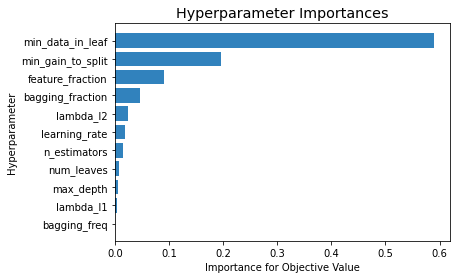

In [29]:
from optuna.visualization.matplotlib import plot_param_importances

plot_param_importances(study);

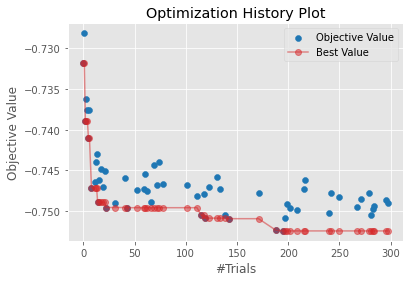

In [30]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study);

In [31]:
## best params found with optuna
params = {'n_estimators': 10000,
 'learning_rate': 0.1791352346972678,
 'num_leaves': 2484,
 'max_depth': 7,
 'min_data_in_leaf': 1000,
 'lambda_l1': 0.001416929031249321,
 'lambda_l2': 5,
 'min_gain_to_split': 6.936460637257937,
 'bagging_fraction': 0.9,
 'bagging_freq': 1,
 'feature_fraction': 0.5}

In [32]:
clf = LGBMClassifier(seed=SEED ,**params).fit(X_train, y_train)
print(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]) , roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))

0.7437527844830579 0.771705955067727


In [33]:
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(LGBMClassifier(seed=SEED ,**params ,n_jobs= -1) ,n_estimators=100 ,random_state =SEED,verbose =2)
clf.fit(X, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Building estimator 1 of 100 for this parallel run (total 100)...
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.001416929031249321, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001416929031249321
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] seed is set=42, random_state=1952926171 will be ignored. Current value: seed=42
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=6.936460637257937, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.936460637257937
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignore

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 183.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 183.8min finished


BaggingClassifier(base_estimator=LGBMClassifier(bagging_fraction=0.9,
                                                bagging_freq=1,
                                                feature_fraction=0.5,
                                                lambda_l1=0.001416929031249321,
                                                lambda_l2=5,
                                                learning_rate=0.1791352346972678,
                                                max_depth=7,
                                                min_data_in_leaf=1000,
                                                min_gain_to_split=6.936460637257937,
                                                n_estimators=10000,
                                                num_leaves=2484, seed=42),
                  n_estimators=100, random_state=42, verbose=2)

In [34]:
out = clf.predict_proba(test_df[list(test_df.columns[1:])])[:,1]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.0s finished


In [35]:
out_df = pd.DataFrame({'cancelled' : out} , index = test_df.order_id)

In [36]:
out_df.reset_index(inplace =True)

In [37]:
out_df.to_csv('/kaggle/working/submission.csv' ,index =False)